In [2]:
import sys
sys.path.append(".")

from raise_utils.hyperparams import DODGE
# We have to define the Wrapper Class for each model and import it as follows
from RandomForest import RandomForest
from NaiveBayes import NaiveBayes
from BiLSTM import BILSTM

from raise_utils.data import DataLoader, Data


import numpy as np
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from bs4 import BeautifulSoup
import string
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import metrics
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer

## Process the data as needed

In [3]:
df = pd.read_csv('C3_anonymized.csv', delimiter=',', usecols=['comment_text','constructive_binary'])

In [4]:
def text_clean(review):
    rv_text = BeautifulSoup(review, 'html.parser').get_text()
    rv_text = re.sub('[^a-zA-Z]', ' ', rv_text)
    rv_text = rv_text.strip()
    return rv_text

In [5]:
clean_comments = df.apply(lambda x: text_clean(x['comment_text']),axis=1)

In [6]:
tk = text.Tokenizer(num_words=20000)
tk.fit_on_texts(clean_comments.tolist())
X = tk.texts_to_sequences(clean_comments)
allX = sequence.pad_sequences(X, maxlen=150)
ally = LabelEncoder().fit_transform(df['constructive_binary'])
word_index = tk.word_index

Class=1, n=6516 (54.300%)
Class=0, n=5484 (45.700%)


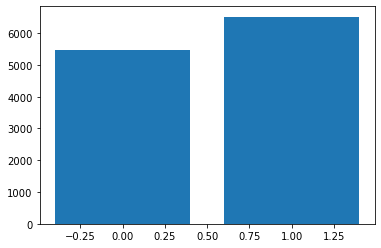

In [7]:
counter = Counter(ally)

for k,v in counter.items():
	per = v / len(ally) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

Class=0, n=6000 (50.000%)
Class=1, n=6000 (50.000%)


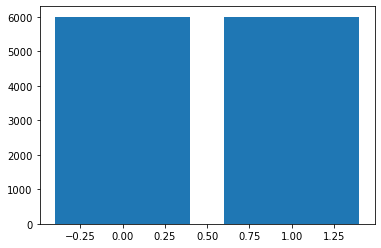

In [8]:
oversample = SMOTE(sampling_strategy={0:6000})
#oversample = SMOTE()
allX, ally = oversample.fit_resample(allX, ally)

under = RandomUnderSampler({1:6000})
allX, ally = under.fit_resample(allX, ally)
# summarize distribution
counter = Counter(ally)
#print(counter)
for k,v in counter.items():
	per = v / len(ally) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [9]:
glv_embed_dict = {}
glv = open('../glove.6B/glove.6B.300d.txt',encoding="utf8")
for line in glv:
    v = line.split()
    word = v[0]
    try:
        vector = np.asarray(v[1:], dtype='float32')
    except:
        pass
    glv_embed_dict[word] = vector
glv.close()

In [10]:
word_embd = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embed_vector = glv_embed_dict.get(word)
    if embed_vector is not None:
        word_embd[i] = embed_vector

In [11]:
X_train, X_test, y_train, y_test = train_test_split(allX, ally,stratify=ally,test_size=0.25)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

## Load the Data using raiseUtils Method.

In [12]:
dt = Data(X_train, X_test, y_train, y_test)

## Generate all Models to be used in Dodge

In [13]:
learners = [
    NaiveBayes(random=True, name="nv1"),
    NaiveBayes(random=True, name="nv2"),
    NaiveBayes(random=True, name="nv3"),
    NaiveBayes(random=True, name="nv4"),
    NaiveBayes(random=True, name="nv5"),
    NaiveBayes(random=True, name="nv6"),
    NaiveBayes(random=True, name="nv7"),
    NaiveBayes(random=True, name="nv8"),
    NaiveBayes(random=True, name="nv9"),
    NaiveBayes(random=True, name="nv10")
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="0"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="1"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="2"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="3"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="4"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="5"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="6"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="7"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="8"),
    #BILSTM(max_words=len(word_index)+1, embedding=300, n_layers=1, input_lenght = dt.x_train.shape[1], random=True, name="9")
            ]

## Sample Dodge Code.

In [14]:
config = {
        "n_runs": 3,
        "transforms": ["standardize"],
        "n_iters": int(len(learners)/3+1),
        "metrics": ["f1", "pd", "pf", "auc", "prec"],
        "random": True,
        "learners": learners,
        "log_path": "",
        "data": [dt],
        "name": "log/camel-pd-pf"
    }

dodge = DODGE(config)


## Run the dodge optimization algorithm

In [15]:
dodge.optimize()

{'hooks': None, 'learner': GaussianNB(var_smoothing=1e-08), 'name': 'nv1', 'random': True, 'random_map': {'var_smoothing': [1e-10, 1e-09, 1e-08]}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': GaussianNB(), 'name': 'nv2', 'random': True, 'random_map': {'var_smoothing': [1e-10, 1e-09, 1e-08]}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': GaussianNB(), 'name': 'nv3', 'random': True, 'random_map': {'var_smoothing': [1e-10, 1e-09, 1e-08]}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': GaussianNB(var_smoothing=1e-08), 'name': 'nv4', 'random': True, 'random_map': {'var_smoothing': [1e-10, 1e-09, 1e-08]}, 'x_test': None, 'x_train': None, 'y_test': None, 'y_train': None}
{'hooks': None, 'learner': GaussianNB(var_smoothing=1e-08), 'name': 'nv5', 'random': True, 'random_map': {'var_smoothing': [1e-10, 1e-09, 1e-08]}, 'x_test': None, 'x_train': None, 'y_tes